# Conditional_GAN in PyTorch

Generative adversarial network (GAN) are well-known deep generative models proposed by [Ian Goodfellow](https://www.iangoodfellow.com) that could be used for synthesising data. It consists of two components, a generator (G) network that learns the data distribution and generates new examples and a discriminator (D) network that distinguishes between real and fake examples i.e. examples generated by G. 

Prior to the assignment, it is necessary to install a package manager e.g. [conda](https://docs.conda.io/en/latest/), and [PyTorch](https://pytorch.org) framework.

## 1. Conditional GAN (cGAN)

Vanilla GANs produce synthetic images by drawing a random vector from latent space. However, we may condition the GAN to additional information, namely, a class label e.g. label  "0" in MNIST. This requires to additionally input the label to G and D networks along with random vector drawn from latent space.

In [27]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.label_emb = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

In [28]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.label_emb = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 28, 28)

In [29]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)


In [30]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

In [41]:
from torch.autograd import Variable
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100)).to(device)
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).to(device)
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).to(device))
    g_loss.backward()
    g_optimizer.step()
    return g_loss.item()

def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).to(device))

    # train with fake images
    z = Variable(torch.randn(batch_size, 100)).to(device)
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).to(device)
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).to(device))

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item()

num_epochs = 20
n_critic = 5
display_step = 50
batch_size = 100
for epoch in range(num_epochs):
    glosses = []
    dlosses = []
    for i, (images, labels) in enumerate(dataloader):
        step = epoch * len(dataloader) + i + 1
        real_images = Variable(images).to(device)
        labels = Variable(labels).to(device)
        generator.train()

        d_loss = 0
        for _ in range(n_critic):
            d_loss = discriminator_train_step(len(real_images), discriminator,
                                              generator, d_optimizer, criterion,
                                              real_images, labels)

        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)
        glosses.append(g_loss)
        dlosses.append(d_loss)

        if step % display_step == 0:
            generator.eval()
            z = Variable(torch.randn(9, 100)).to(device)
            labels = Variable(torch.LongTensor(np.arange(9))).to(device)
            sample_images = generator(z, labels).unsqueeze(1)

    print('Epoch = ',epoch,'d_loss =', d_loss,'g_loss = ',g_loss)


Epoch =  0 d_loss = 0.5244827270507812 g_loss =  2.532242774963379
Epoch =  1 d_loss = 0.4402273893356323 g_loss =  3.1456384658813477
Epoch =  2 d_loss = 0.39285576343536377 g_loss =  2.803809642791748
Epoch =  3 d_loss = 0.6463513970375061 g_loss =  2.1255648136138916
Epoch =  4 d_loss = 0.6485738754272461 g_loss =  2.5948400497436523
Epoch =  5 d_loss = 0.5834769606590271 g_loss =  3.3030169010162354
Epoch =  6 d_loss = 0.6170899271965027 g_loss =  2.4073681831359863
Epoch =  7 d_loss = 0.7198481559753418 g_loss =  1.9058407545089722
Epoch =  8 d_loss = 0.8107094764709473 g_loss =  2.2954351902008057
Epoch =  9 d_loss = 0.738768994808197 g_loss =  1.8415783643722534
Epoch =  10 d_loss = 0.6444283723831177 g_loss =  2.0125904083251953
Epoch =  11 d_loss = 0.8108325004577637 g_loss =  1.9295672178268433
Epoch =  12 d_loss = 0.7827951312065125 g_loss =  2.097609519958496
Epoch =  13 d_loss = 0.7712706923484802 g_loss =  1.6902531385421753
Epoch =  14 d_loss = 0.7428767681121826 g_loss 

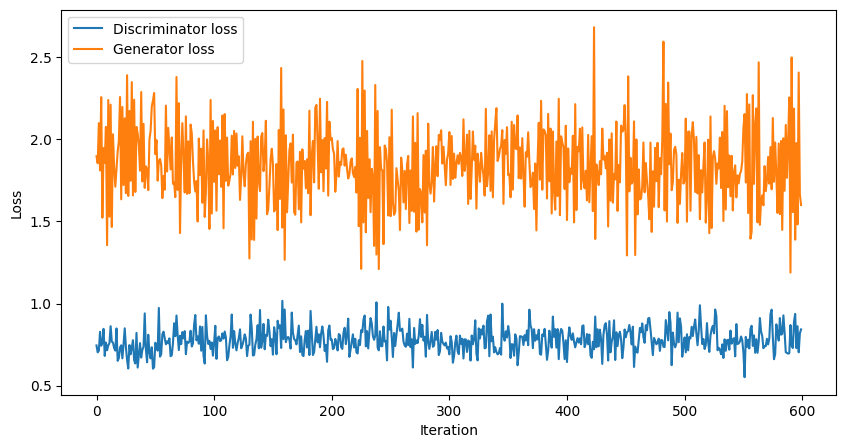

In [43]:
def plot_losses(D_losses, G_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(D_losses, label='Discriminator loss')
    plt.plot(G_losses, label='Generator loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_losses(dlosses, glosses)

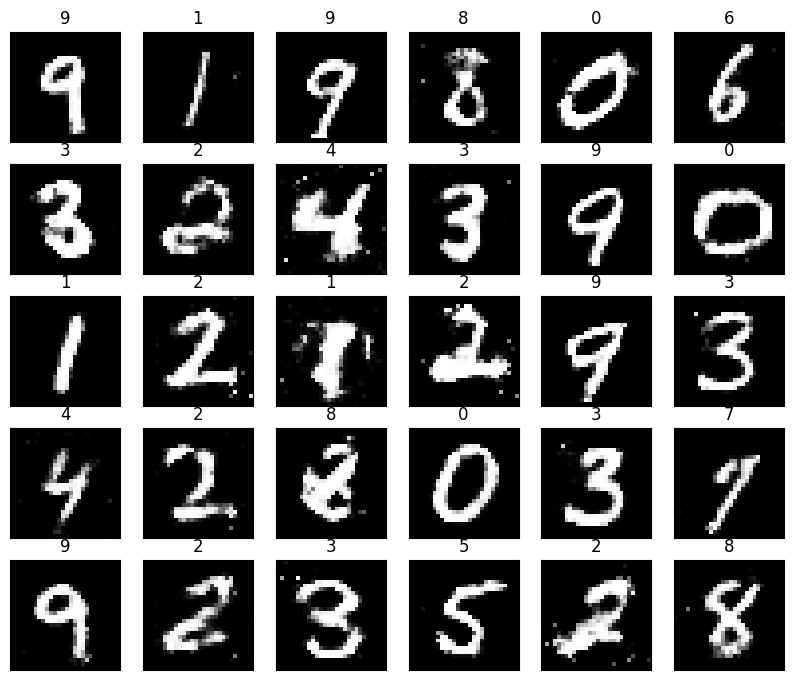

In [54]:
z = Variable(torch.randn(30, 100)).to(device)
labels = Variable(torch.LongTensor(np.random.randint(0, 10, 30))).to(device)
generated_images = generator(z, labels).detach().cpu()

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(6, 6)
for j, sample in enumerate(generated_images):
  ax = plt.subplot(gs[j])
  ax.set_xticks([])
  ax.set_title(labels.detach().cpu().numpy()[j])
  ax.set_yticks([])
  plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

# visualize_generated_images(generator)